<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-12/prepare_policy_scores_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We used to do causal analysis to compare the counties with shelter in place and counties without shelter in place to find out whether shelter in place changes people's behavior. However, shelter in place is just one of the many policies that a county/state can implement. We have found a open source dataset that takes all the policies a state implement into account and gives a "policy" score in terms of how strong the government responded to COVID 19. We want to swap this score for the SIP.

Then we will do causal analysis on a continuous treatment (policy score is continuous). This is utterly new and interesting to me, and it will add a lot to our current analysis.

Therefore the answer we are asking now is: **do the counties with higher policy score change people's behavior more than the counties with lower policy score?**

# 0. Go do data directory

In [1]:
cd drive/My\ Drive/covid/PSM/data

/content/drive/My Drive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
avg_google_mobility_up_to_6_1_weekdays.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
final_data_google_and_safe_graph_up_to_6_1_weekdays.csv
google_mobility.csv
policy_scores.csv
policy_scores_US.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. load policy score data

In [4]:
data = pd.read_csv('policy_scores.csv', parse_dates=['Date'], infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data = data[data['CountryName'] == 'United States']

In [6]:
data['RegionName'].unique()

array([nan, 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland',
       'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi',
       'Montana', 'North Carolina', 'North Dakota', 'Nebraska',
       'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Virgin Islands', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [7]:
data

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
68208,United States,USA,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68209,United States,USA,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68210,United States,USA,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68211,United States,USA,NaN,NaN,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68212,United States,USA,NaN,NaN,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86011,United States,USA,Wyoming,US_WY,STATE_TOTAL,2020-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31773.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86012,United States,USA,Wyoming,US_WY,STATE_TOTAL,2020-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31928.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86013,United States,USA,Wyoming,US_WY,STATE_TOTAL,2020-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32489.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86014,United States,USA,Wyoming,US_WY,STATE_TOTAL,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33305.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. visualizing time series of policy scores

In [8]:
data[data['RegionName'] == 'Washington'][100:105]

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
84772,United States,USA,Washington,US_WA,STATE_TOTAL,2020-04-10,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,10119.0,483.0,79.63,79.63,83.33,83.33,67.86,67.86,68.75,68.75,62.5,62.5
84773,United States,USA,Washington,US_WA,STATE_TOTAL,2020-04-11,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,10434.0,495.0,79.63,79.63,83.33,83.33,67.86,67.86,68.75,68.75,62.5,62.5
84774,United States,USA,Washington,US_WA,STATE_TOTAL,2020-04-12,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,10609.0,506.0,79.63,79.63,83.33,83.33,67.86,67.86,68.75,68.75,62.5,62.5
84775,United States,USA,Washington,US_WA,STATE_TOTAL,2020-04-13,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,10635.0,513.0,79.63,79.63,83.33,83.33,67.86,67.86,68.75,68.75,62.5,62.5
84776,United States,USA,Washington,US_WA,STATE_TOTAL,2020-04-14,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,10799.0,530.0,79.63,79.63,83.33,83.33,67.86,67.86,68.75,68.75,62.5,62.5


In [9]:
data_washington = data[data['RegionName'] == 'Washington']

visualizing Washington's policy score over time

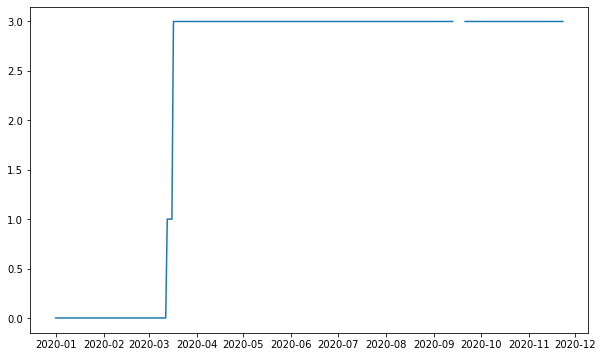

In [11]:
plt.figure(figsize = (10,6))
plt.plot(data_washington['Date'], data_washington['C1_School closing'])

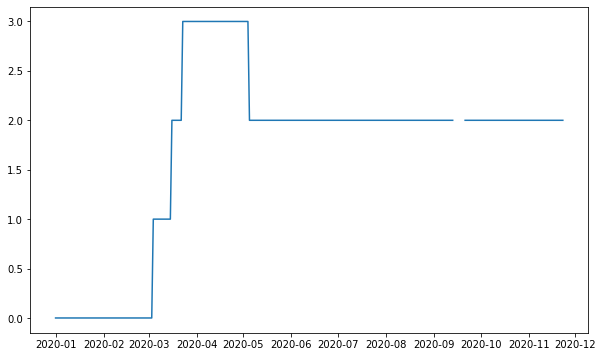

In [12]:
plt.figure(figsize = (10,6))
plt.plot(data_washington['Date'], data_washington['C2_Workplace closing'])

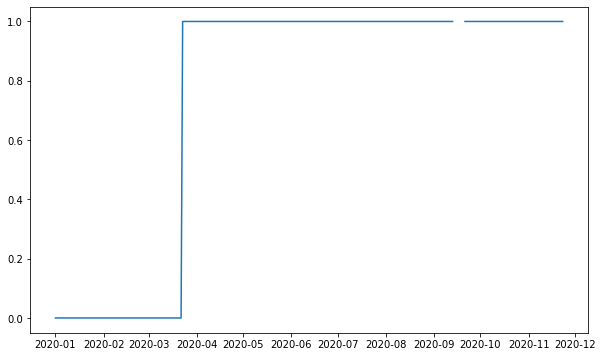

In [13]:
plt.figure(figsize = (10,6))
plt.plot(data_washington['Date'], data_washington['C5_Close public transport'])

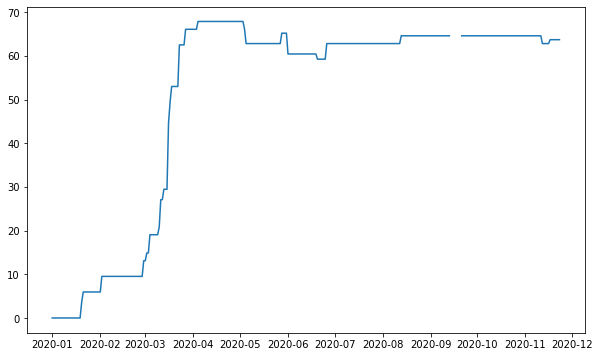

In [14]:
plt.figure(figsize = (10,6))
plt.plot(data_washington['Date'], data_washington['GovernmentResponseIndex'])

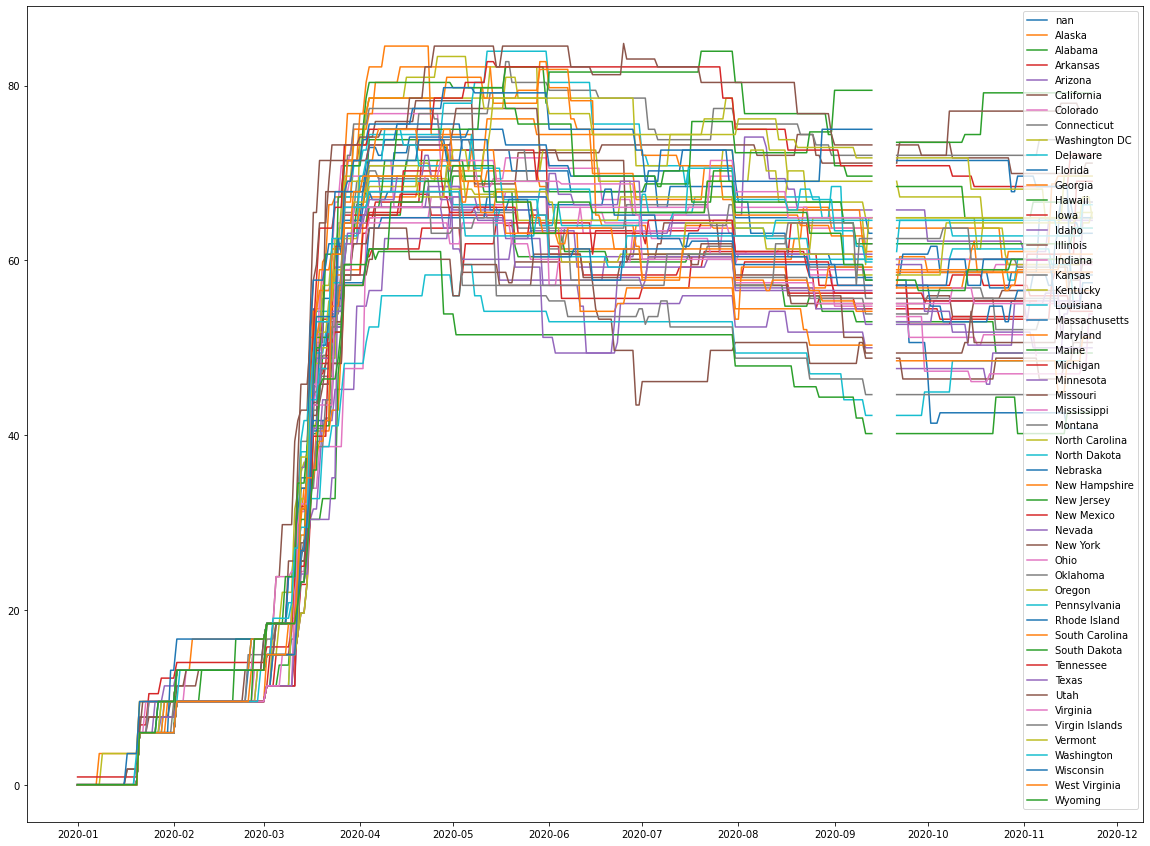

In [15]:
# visualize government response index of every state together
plt.figure(figsize = (20,15))
for state in data['RegionName'].unique():
  this_data = data[data['RegionName'] == state]
  plt.plot(this_data['Date'], this_data['GovernmentResponseIndex'], label = state)
plt.legend()

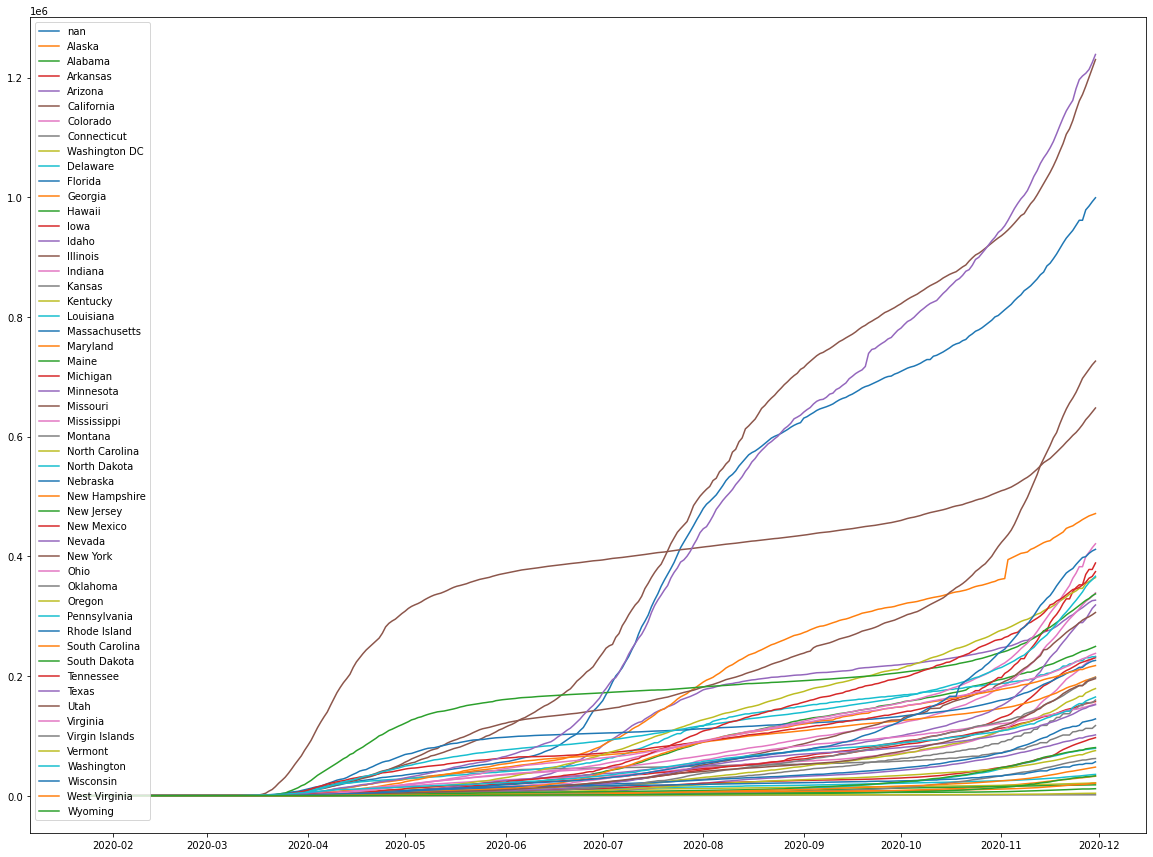

In [16]:
# visualize number of cases over time
plt.figure(figsize = (20,15))
for state in data['RegionName'].unique():
  this_data = data[data['RegionName'] == state]
  plt.plot(this_data['Date'], this_data['ConfirmedCases'], label = state)
plt.legend(loc = 'upper left')

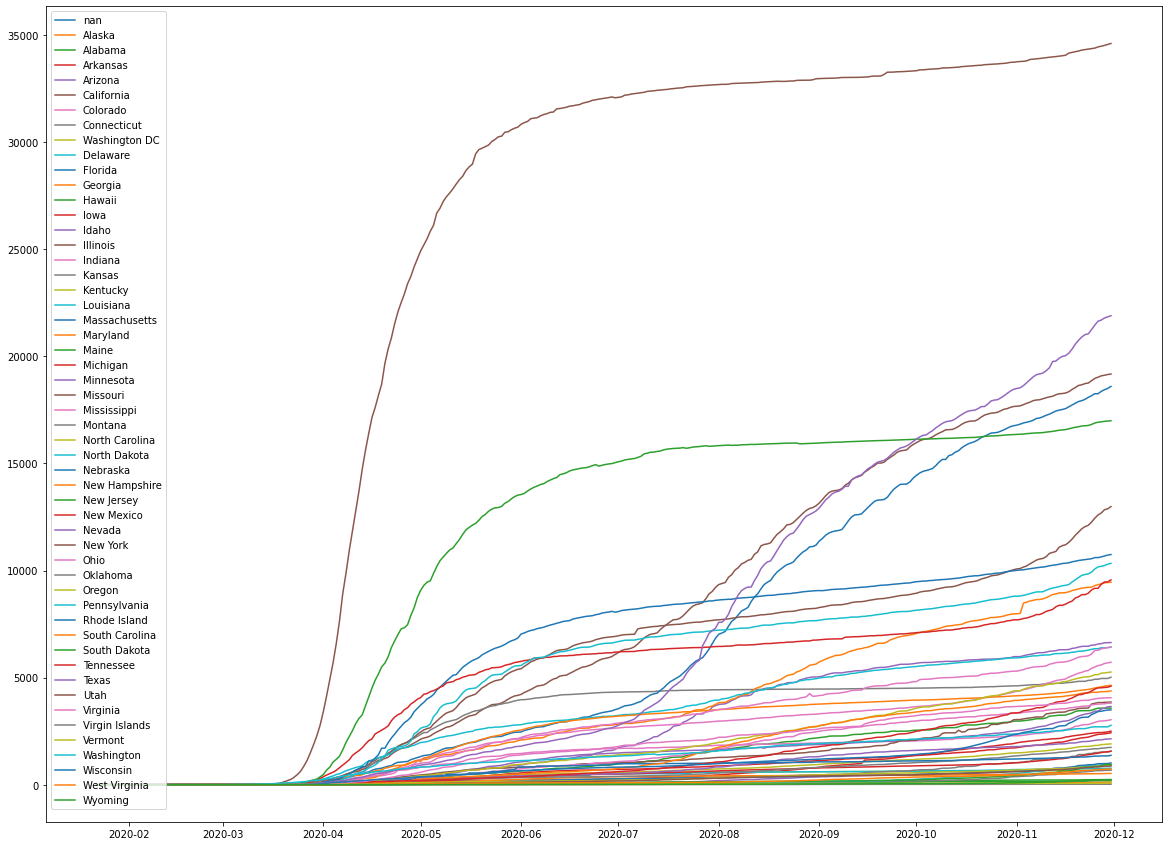

In [17]:
# visualize number of deaths overtime
plt.figure(figsize = (20,15))
for state in data['RegionName'].unique():
  this_data = data[data['RegionName'] == state]
  plt.plot(this_data['Date'], this_data['ConfirmedDeaths'], label = state)
plt.legend(loc = 'upper left')

# 3. get the policy score for each state

Initially we are going to get the average policy score from the start of SIP in each county until 6/1. However, I don't think this makes much sense, since our policy score dataset is associated with each state, and not each county. For now I will just get the average policy score from `4-1-2020` to `6-1-2020` for each state, Later we can switch to the custom date range for each county.

In [18]:
data = data[['RegionName', 'RegionCode', 'Jurisdiction', 'Date', 'GovernmentResponseIndex']]

In [19]:
data

,RegionName,RegionCode,Jurisdiction,Date,GovernmentResponseIndex
68208,NaN,NaN,NAT_TOTAL,2020-01-01,0.0
68209,NaN,NaN,NAT_TOTAL,2020-01-02,0.0
68210,NaN,NaN,NAT_TOTAL,2020-01-03,0.0
68211,NaN,NaN,NAT_TOTAL,2020-01-04,0.0
68212,NaN,NaN,NAT_TOTAL,2020-01-05,0.0
...,...,...,...,...,...
86011,Wyoming,US_WY,STATE_TOTAL,2020-11-27,NaN
86012,Wyoming,US_WY,STATE_TOTAL,2020-11-28,NaN
86013,Wyoming,US_WY,STATE_TOTAL,2020-11-29,NaN
86014,Wyoming,US_WY,STATE_TOTAL,2020-11-30,NaN


In [20]:
data['Jurisdiction'].unique()

array(['NAT_TOTAL', 'STATE_TOTAL'], dtype=object)

In [21]:
# we are doing research on each state/county. Let's get
# rid of the rows that indicate the national response level.
data = data[data['Jurisdiction'] == 'STATE_TOTAL']

In [22]:
data

,RegionName,RegionCode,Jurisdiction,Date,GovernmentResponseIndex
68544,Alaska,US_AK,STATE_TOTAL,2020-01-01,0.0
68545,Alaska,US_AK,STATE_TOTAL,2020-01-02,0.0
68546,Alaska,US_AK,STATE_TOTAL,2020-01-03,0.0
68547,Alaska,US_AK,STATE_TOTAL,2020-01-04,0.0
68548,Alaska,US_AK,STATE_TOTAL,2020-01-05,0.0
...,...,...,...,...,...
86011,Wyoming,US_WY,STATE_TOTAL,2020-11-27,NaN
86012,Wyoming,US_WY,STATE_TOTAL,2020-11-28,NaN
86013,Wyoming,US_WY,STATE_TOTAL,2020-11-29,NaN
86014,Wyoming,US_WY,STATE_TOTAL,2020-11-30,NaN


In [23]:
data = data.drop(['RegionCode', 'Jurisdiction'], axis = 1)

In [24]:
data

,RegionName,Date,GovernmentResponseIndex
68544,Alaska,2020-01-01,0.0
68545,Alaska,2020-01-02,0.0
68546,Alaska,2020-01-03,0.0
68547,Alaska,2020-01-04,0.0
68548,Alaska,2020-01-05,0.0
...,...,...,...
86011,Wyoming,2020-11-27,NaN
86012,Wyoming,2020-11-28,NaN
86013,Wyoming,2020-11-29,NaN
86014,Wyoming,2020-11-30,NaN


In [28]:
# given a start date and a end date, and a dataframe with dates variable
# return the new dataset that has only rows with start date <= date <= end date.
def filterDates(start_date = np.datetime64('2020-04-01'), end_date = np.datetime64('2020-06-01'), dataset = data, dateColumn = 'date'):

  def isThisRowAfterDate(row, date):
    return row[dateColumn] >= date
  def isThisRowBeforeDate(row, date):
    return row[dateColumn] <= date
  
  newData = dataset[dataset.apply(lambda row: isThisRowAfterDate(row, start_date) and isThisRowBeforeDate(row, end_date), axis = 1)]

  return newData

In [30]:
data = filterDates(dataset = data, dateColumn='Date')

In [31]:
data

,RegionName,Date,GovernmentResponseIndex
68635,Alaska,2020-04-01,76.79
68636,Alaska,2020-04-02,76.79
68637,Alaska,2020-04-03,80.36
68638,Alaska,2020-04-04,82.14
68639,Alaska,2020-04-05,82.14
...,...,...,...
85828,Wyoming,2020-05-28,63.10
85829,Wyoming,2020-05-29,63.10
85830,Wyoming,2020-05-30,63.10
85831,Wyoming,2020-05-31,63.10


In [32]:
data_agg = data.groupby(['RegionName'])\
  .agg(GovernmentResponseIndex = ('GovernmentResponseIndex', 'mean')).reset_index()

In [33]:
data_agg

,RegionName,GovernmentResponseIndex
0,Alabama,69.134839
1,Alaska,75.651129
2,Arizona,61.261774
3,Arkansas,62.558065
4,California,74.186613
5,Colorado,73.298871
6,Connecticut,76.110484
7,Delaware,78.417258
8,Florida,72.976452
9,Georgia,71.121129


In [34]:
data_agg['GovernmentResponseIndex'].max()

81.29096774193556

In [36]:
data_agg[data_agg['GovernmentResponseIndex'] >= 80]

,RegionName,GovernmentResponseIndex
18,Maine,80.280484
19,Maryland,80.376452
31,New York,81.290968


In [35]:
data_agg['GovernmentResponseIndex'].min()

55.308709677419365

In [37]:
data_agg[data_agg['GovernmentResponseIndex'] <= 60]

,RegionName,GovernmentResponseIndex
33,North Dakota,55.308710
40,South Dakota,55.635806


In [38]:
data.to_csv("final_policy_scores.csv", index = False)

# 4. merge policy score data with our current behavioral data

In [39]:
policy_score_data = data_agg

In [40]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
avg_google_mobility_up_to_6_1_weekdays.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
final_data_google_and_safe_graph_up_to_6_1_weekdays.csv
final_policy_scores.csv
google_mobility.csv
policy_scores.csv
social_dist_aggregated_on_county.csv


In [41]:
behavioral_data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [42]:
behavioral_data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3
2992,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5
2993,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4
2994,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4


In [43]:
policy_score_data

,RegionName,GovernmentResponseIndex
0,Alabama,69.134839
1,Alaska,75.651129
2,Arizona,61.261774
3,Arkansas,62.558065
4,California,74.186613
5,Colorado,73.298871
6,Connecticut,76.110484
7,Delaware,78.417258
8,Florida,72.976452
9,Georgia,71.121129


In [45]:
merged_data = behavioral_data.merge(policy_score_data, left_on= 'State Name', right_on = 'RegionName')

In [46]:
merged_data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,RegionName,GovernmentResponseIndex
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,Alabama,69.134839
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,Alabama,69.134839
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,Alabama,69.134839
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,Alabama,69.134839
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,Alabama,69.134839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,Wyoming,66.658226
2991,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,Wyoming,66.658226
2992,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,Wyoming,66.658226
2993,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,Wyoming,66.658226


In [49]:
merged_data[merged_data['State Name'] == 'Alabama']

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,RegionName,GovernmentResponseIndex
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,Alabama,69.134839
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,Alabama,69.134839
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,Alabama,69.134839
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,Alabama,69.134839
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,Alabama,69.134839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.0,AL,Alabama,Tuscaloosa County,1125.0,0.025350,1,52557.0,25.5,208911,-0.195269,20.9,13.3,1.6,31.8,3.9,61.2,Alabama,69.134839
63,1.0,AL,Alabama,Walker County,1127.0,0.010729,1,45434.0,74.1,63711,-0.674418,22.2,19.3,0.6,6.1,2.6,88.9,Alabama,69.134839
64,1.0,AL,Alabama,Washington County,1129.0,0.013335,1,44424.0,100.0,16378,-0.431583,22.0,19.1,0.9,23.3,1.6,65.1,Alabama,69.134839
65,1.0,AL,Alabama,Wilcox County,1131.0,0.030107,1,25385.0,100.0,10627,0.425267,23.8,19.4,0.2,70.7,1.4,26.6,Alabama,69.134839


In [52]:
merged_data = merged_data.drop(['RegionName'], axis = 1)

In [53]:
merged_data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,GovernmentResponseIndex
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,69.134839
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,69.134839
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,69.134839
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,69.134839
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,69.134839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,66.658226
2991,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,66.658226
2992,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,66.658226
2993,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,66.658226


In [54]:
merged_data.to_csv('data_with_policy_scores.csv', index = False)